# 1. Pre-Setup

## Install Packages

In [1]:
!pip install roboflow --quiet
!pip install pycocotools --quiet
!pip install albumentations --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 36.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 97.0 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sigstore 3.6.1 requires rich~=13.0, but you have rich 14.0.0 which is incompatible.
datasets 3.5.0 requires fsspec[http]<=2024.12.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
nilearn 0.11.1 requires scikit-learn>=1.4.0, but you have scikit-learn 1.2.2 which is incompatible.
google-colab 1.0.0 requires notebook==6.5.5, but you have notebook 6.5.4 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
google-

## Import Libraries

In [2]:
import torch
import torchvision
import torchvision.transforms as T
import torch.utils.data
from torch.utils.data import DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import RetinaNet
from torchvision.models.detection.retinanet import RetinaNetHead
from torchvision.datasets import CocoDetection
from torch.utils.data import ConcatDataset

import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
import random
import time
from PIL import Image
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, ConfusionMatrixDisplay

from roboflow import Roboflow

import matplotlib.patches as patches

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Download Dataset from Roboflow

In [3]:
# Download the dataset
API_KEY = "4PCfwxj1tbPm25eqqLhX"

rf = Roboflow(api_key=API_KEY)
project = rf.workspace("dent-ydn9e").project("defect-detection-rhju6")
version = project.version(1)
dataset = version.download("coco")
data_dir = dataset.location

print("Downloaded to:", data_dir)

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Defect-Detection-1 in coco:: 100%|██████████| 2753/2753 [00:01<00:00, 1901.64it/s]


Downloaded to: /kaggle/working/Defect-Detection-1


# 2. Hyperparameters and Configs

## Dataset Configs

In [4]:
# Set dataset paths
train_dir = os.path.join(data_dir, "train")
valid_dir = os.path.join(data_dir, "valid")
test_dir  = os.path.join(data_dir, "test")

## Augmentation Hyperparameters

In [5]:
augmentation_hyperparameters = {
    'resize':  { 'height': 512, 'width': 512 },
    'jitter': dict(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02, p=0.5),
    'rotate': dict(limit=10, p=0.5, border_mode=0),
    'hflip': dict(p=0.5),
    'vflip': dict(p=0.5),
}

## Dataset Preparation Hyperparameters

In [6]:
batch_size_train = 4
batch_size_valid = 2
batch_size_test = 2

# Define valid classes to detect: Only use these valid classes (ignore others)
VALID_CLASSES = {
    "dent_marginal": 1,
    "dent_unacceptable": 2
}

## Model Training Hyperparameters

In [7]:
learning_rate = 0.005
momentum = 0.9
weight_decay = 0.0005

step_size = 3
gamma = 0.1

num_epochs = 10

iou_threshold = 0.5

## Visualization Hyperparameters

In [8]:
score_threshold = 0.5  # For visualization threshold

# 3. Data Preparation

## Define Dataset Class

In [9]:
def reduce_dataset(dataset, ratio=0.5):
    indices = torch.randperm(len(dataset)).tolist()
    reduced_size = int(len(dataset) * ratio)
    dataset.ids = [dataset.ids[i] for i in indices[:reduced_size]]
    
    return dataset

In [10]:
class DefectDetectionDataset(CocoDetection):
    def __init__(self, img_folder, ann_file, transforms=None):
        super().__init__(img_folder, ann_file)
        self._transforms = transforms
        self.valid_class_ids = set(VALID_CLASSES.values())

        # Precompute valid IDs
        self.valid_ids = []
        for idx in range(len(self.ids)):
            anns = self.coco.loadAnns(self.ids[idx])
            if any(ann['category_id'] in self.valid_class_ids for ann in anns):
                self.valid_ids.append(self.ids[idx])

        self.ids = self.valid_ids

    def __getitem__(self, idx):
        img, _ = super().__getitem__(idx)
        img = np.array(img)  # Convert PIL image to numpy array for Albumentations
        h, w = img.shape[:2]

        ann_ids = self.coco.getAnnIds(imgIds=self.ids[idx])
        anns = self.coco.loadAnns(ann_ids)

        boxes, labels = [], []
        for ann in anns:
            if ann['category_id'] in self.valid_class_ids:
                xmin, ymin, width, height = ann['bbox']
                # Convert to absolute coordinates and clip to image dimensions
                xmin = max(0, min(xmin, w-1))
                ymin = max(0, min(ymin, h-1))
                xmax = max(0, min(xmin + width, w-1))
                ymax = max(0, min(ymin + height, h-1))
                if xmax > xmin and ymax > ymin:  # Only keep valid boxes
                    boxes.append([xmin, ymin, xmax, ymax])
                    labels.append(ann['category_id'])

        if self._transforms:
            try:
                transformed = self._transforms(
                    image=img,
                    bboxes=boxes,
                    labels=labels
                )
                img = transformed['image']
                boxes = transformed['bboxes']
                labels = transformed['labels']
            except Exception as e:
                print(f"Transform failed for image {self.ids[idx]}: {e}")
                # Fallback to just transforming the image
                img = self._transforms(image=img)['image']
                boxes = []
                labels = []

        # Convert to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0, 4))
        labels = torch.as_tensor(labels, dtype=torch.int64) if labels else torch.zeros((0,), dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([self.ids[idx]])
        }

        return img, target

## Transform Function

### Calculate Mean and Std of Dataset

In [11]:
def calculate_dataset_stats(dataset, num_samples=None):
    """
    Calculate mean and std of dataset images
    Args:
        dataset: PyTorch dataset
        num_samples: Number of samples to use (None for all)
    """
    if num_samples is None:
        num_samples = len(dataset)
    else:
        num_samples = min(num_samples, len(dataset))

    # Initialize accumulators
    pixel_sum = torch.zeros(3)
    pixel_sq_sum = torch.zeros(3)
    num_pixels = 0

    # Use random samples for efficiency
    indices = torch.randperm(len(dataset))[:num_samples]

    for idx in tqdm(indices, desc="Calculating stats"):
        img, _ = dataset[int(idx)]

        if isinstance(img, np.ndarray):
            img = torch.from_numpy(img).permute(2, 0, 1)  # HWC to CHW
        elif isinstance(img, torch.Tensor):
            if img.ndim == 3 and img.shape[0] != 3:  # If not CHW
                img = img.permute(2, 0, 1)

        img = img.float() / 255.0  # Normalize to [0,1]

        pixel_sum += img.sum(dim=[1, 2])
        pixel_sq_sum += (img**2).sum(dim=[1, 2])
        num_pixels += img.shape[1] * img.shape[2]

    mean = pixel_sum / num_pixels
    std = torch.sqrt((pixel_sq_sum / num_pixels) - mean**2)

    return mean.tolist(), std.tolist()

In [13]:
temp_dataset = DefectDetectionDataset(train_dir, os.path.join(train_dir, "_annotations.coco.json"), transforms=None)
mean, std = calculate_dataset_stats(temp_dataset)

print(f"Calculated mean: {mean}")
print(f"Calculated std: {std}")

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


Calculating stats:   3%|▎         | 63/1920 [00:05<02:28, 12.49it/s]


KeyboardInterrupt: 

In [12]:
def get_transform(aug=True):
    if aug:
        # Training pipeline: resize → augment → normalize → tensor
        return A.Compose(
            [
                A.Resize(**augmentation_hyperparameters['resize']),
                A.ColorJitter(**augmentation_hyperparameters['jitter']),
                A.Rotate(**augmentation_hyperparameters['rotate']),
                A.HorizontalFlip(**augmentation_hyperparameters['hflip']),
                A.VerticalFlip(**augmentation_hyperparameters['vflip']),
                A.Normalize(mean=[0.25295597314834595, 0.23075896501541138, 0.26414644718170166], std=[0.27508845925331116, 0.2542201280593872, 0.2752417325973511]),
                ToTensorV2(),
            ],
            bbox_params=A.BboxParams(
                format='pascal_voc',
                label_fields=['labels'],
                clip=True,
                min_visibility=0.3
            )
        )

    # Validation pipeline: resize → normalize → tensor
    return A.Compose(
        [
            A.Resize(**augmentation_hyperparameters['resize']),
            A.Normalize(mean=[0.25295597314834595, 0.23075896501541138, 0.26414644718170166], std=[0.27508845925331116, 0.2542201280593872, 0.2752417325973511]),
            ToTensorV2(),
        ],
        bbox_params=A.BboxParams(
            format='pascal_voc',
            label_fields=['labels'],
            clip=True,
            min_visibility=0.3
        )
        )

## Load Datasets and DataLoaders

In [13]:

train_dataset = DefectDetectionDataset(train_dir,os.path.join(train_dir, "_annotations.coco.json"),transforms=get_transform(aug=True))
valid_dataset = DefectDetectionDataset(valid_dir, os.path.join(valid_dir, "_annotations.coco.json"), transforms=get_transform(aug=False))
test_dataset  = DefectDetectionDataset(test_dir,  os.path.join(test_dir, "_annotations.coco.json"), transforms=get_transform(aug=False))


train_dataset = reduce_dataset(train_dataset, 0.5)
# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
valid_loader = DataLoader(valid_dataset, batch_size=batch_size_valid, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
test_loader  = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

print(f"Train Samples: {len(train_dataset)}, Valid Samples: {len(valid_dataset)}, Test Samples: {len(test_dataset)}")

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Train Samples: 960, Valid Samples: 548, Test Samples: 277


In [17]:
def visualize_dataset(dataset, num_images=5, denormalize=True):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))

    # Get random indices for visualization
    indices = np.random.choice(len(dataset), num_images, replace=False)

    for i, idx in enumerate(indices):
        # Get image and target
        image, target = dataset[int(idx)]

        # Handle different image formats
        if isinstance(image, torch.Tensor):
            image = image.permute(1, 2, 0).cpu().numpy()  # Convert from CxHxW to HxWxC

            # Denormalize if needed
            if denormalize:
                mean = np.array([0.2529558539390564, 0.23075897991657257, 0.26414594054222107])
                std = np.array([0.2750886380672455, 0.25421997904777527, 0.27524229884147644])
                image = (image * std) + mean  # Reverse normalization
                image = np.clip(image * 255, 0, 255).astype(np.uint8)  # Clip to valid range

        boxes = target["boxes"].cpu().numpy() if isinstance(target["boxes"], torch.Tensor) else target["boxes"]
        labels = target["labels"].cpu().numpy() if isinstance(target["labels"], torch.Tensor) else target["labels"]

        ax = axes[i]
        ax.imshow(image)
        ax.set_title(f"Image {idx}")
        ax.axis("off")

        # Draw bounding boxes
        for box in boxes:
            # Note: Your boxes are in [xmin, ymin, xmax, ymax] format (pascal_voc)
            xmin, ymin, xmax, ymax = box
            width = xmax - xmin
            height = ymax - ymin

            rect = patches.Rectangle(
                (xmin, ymin),
                width,
                height,
                linewidth=2,
                edgecolor='r',
                facecolor='none'
            )
            ax.add_patch(rect)

    plt.tight_layout()
    plt.show()


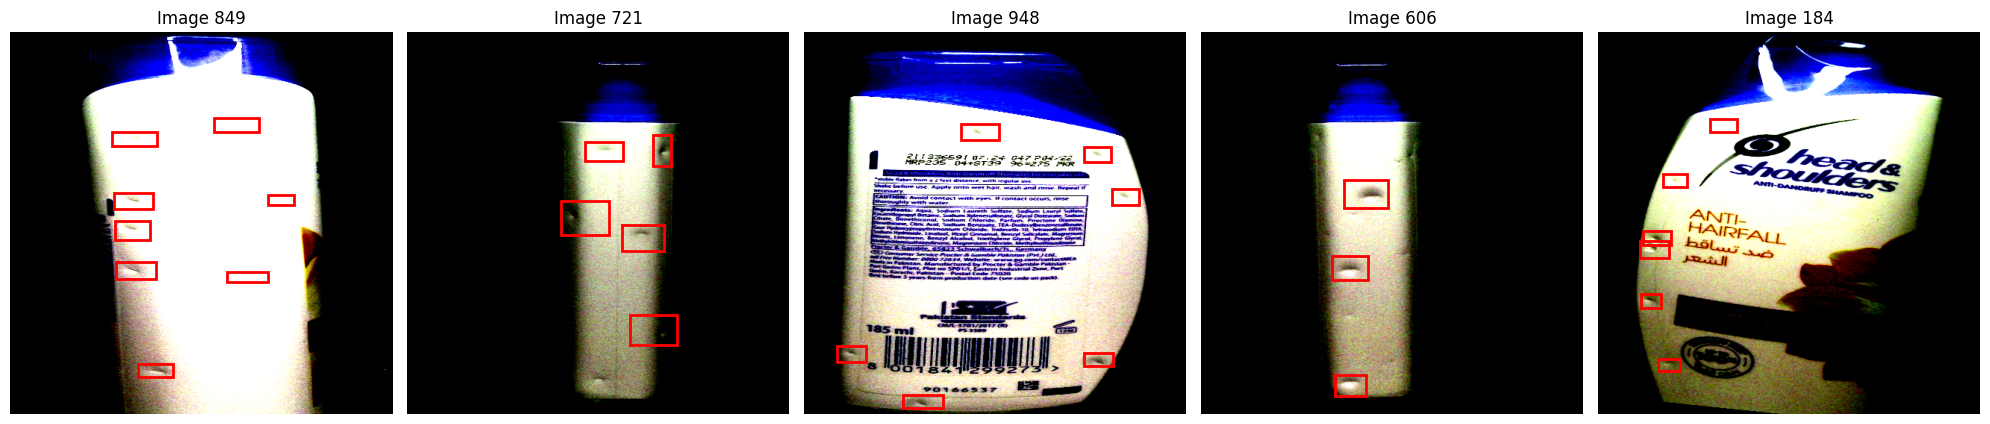

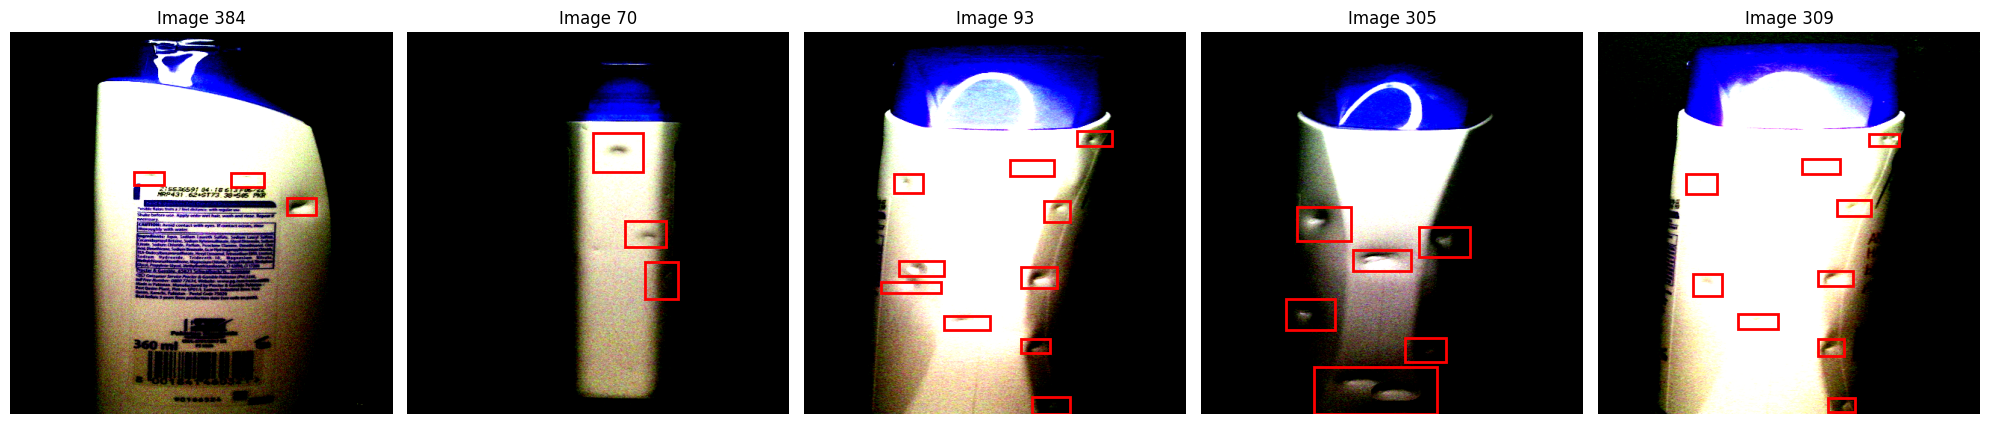

In [18]:
# Visualize examples
visualize_dataset(train_dataset,5,False)
visualize_dataset(valid_dataset,5,False)

# 4. Training and Evaluation Functions

## Training Function

In [14]:
import torch

def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=50):
    model.train()
    running_loss = 0.0
    running_loss_dict = {}

    for batch_idx, (images, targets) in enumerate(data_loader):
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        total_loss = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Update total running loss
        running_loss += total_loss.item()

        # Also keep track of each component loss separately
        for k, v in loss_dict.items():
            if k not in running_loss_dict:
                running_loss_dict[k] = 0.0
            running_loss_dict[k] += v.item()

        # Print every print_freq batches
        if (batch_idx + 1) % print_freq == 0:
            loss_str = " | ".join([f"{k}: {v / (batch_idx+1):.4f}" for k, v in running_loss_dict.items()])
            print(f"[Epoch {epoch+1}] [Batch {batch_idx+1}/{len(data_loader)}] Total Loss: {running_loss / (batch_idx+1):.4f} | {loss_str}")

    # Return average losses
    avg_total_loss = running_loss / len(data_loader)
    avg_loss_dict = {k: v / len(data_loader) for k, v in running_loss_dict.items()}
    return avg_total_loss, avg_loss_dict


## Evaluation Function

In [15]:
@torch.no_grad()
def evaluate(model, data_loader, device, epoch=None, print_freq=50):
    model.train()
    running_loss = 0.0

    for batch_idx, (images, targets) in enumerate(data_loader):
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        running_loss += losses.item()

        if (batch_idx + 1) % print_freq == 0:
            if epoch is not None:
                print(f"[Epoch {epoch+1}] [Batch {batch_idx+1}/{len(data_loader)}] Validating...")

    return running_loss / len(data_loader)

## Calculate IOU Function

In [16]:
def calculate_iou(box1, box2):
    x1, y1 = max(box1[0], box2[0]), max(box1[1], box2[1])
    x2, y2 = min(box1[2], box2[2]), min(box1[3], box2[3])
    inter_area = max(0, x2 - x1) * max(0, y2 - y1)

    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union_area = box1_area + box2_area - inter_area
    if union_area == 0:
        return 0
    return inter_area / union_area

## Calculate Precision-Recall Function

In [17]:
def calculate_precision_recall(scores, matches):
    if len(scores) == 0:
        return np.array([0]), np.array([0])

    scores = np.array(scores)
    matches = np.array(matches)

    indices = np.argsort(-scores)
    matches = matches[indices]

    tp = np.cumsum(matches)
    fp = np.cumsum(1 - matches)

    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp[-1] + 1e-6)

    return precision, recall

## Calculate mAP Function

In [18]:
def calculate_map(scores, matches):
    precision, recall = calculate_precision_recall(scores, matches)
    ap = 0
    for t in np.linspace(0, 1, 11):
        p = precision[recall >= t]
        if p.size > 0:
            ap += np.max(p)
    return ap / 11

## Compute mAP and PR Curves Function

In [19]:
@torch.no_grad()
def compute_map_and_pr_curves(model, data_loader, device, iou_threshold=iou_threshold):
    model.eval()

    all_scores = []
    all_matches = []

    per_class_scores = {c: [] for c in VALID_CLASSES.values()}
    per_class_matches = {c: [] for c in VALID_CLASSES.values()}

    for images, targets in data_loader:
        images = list(img.to(device) for img in images)
        outputs = model(images)

        for output, target in zip(outputs, targets):
            pred_boxes = output['boxes'].cpu().numpy()
            pred_scores = output['scores'].cpu().numpy()
            pred_labels = output['labels'].cpu().numpy()

            gt_boxes = target['boxes'].numpy()
            gt_labels = target['labels'].numpy()

            keep = pred_scores >= 0.3
            pred_boxes = pred_boxes[keep]
            pred_scores = pred_scores[keep]
            pred_labels = pred_labels[keep]

            matched = np.zeros(len(pred_boxes))

            for gt_idx, gt_box in enumerate(gt_boxes):
                best_iou, best_idx = 0, -1
                for pred_idx, pred_box in enumerate(pred_boxes):
                    iou = calculate_iou(gt_box, pred_box)
                    if iou > best_iou:
                        best_iou = iou
                        best_idx = pred_idx

                if best_iou >= iou_threshold:
                    matched[best_idx] = 1

            all_scores.extend(pred_scores.tolist())
            all_matches.extend(matched.tolist())

            for c in VALID_CLASSES.values():
                gt_class_boxes = gt_boxes[gt_labels == c]
                pred_class_boxes = pred_boxes[pred_labels == c]
                pred_class_scores = pred_scores[pred_labels == c]

                matched_c = np.zeros(len(pred_class_boxes))

                for gt_idx, gt_box in enumerate(gt_class_boxes):
                    best_iou_c, best_idx_c = 0, -1
                    for pred_idx, pred_box in enumerate(pred_class_boxes):
                        iou = calculate_iou(gt_box, pred_box)
                        if iou > best_iou_c:
                            best_iou_c = iou
                            best_idx_c = pred_idx

                    if best_iou_c >= iou_threshold:
                        if best_idx_c != -1:
                            matched_c[best_idx_c] = 1

                per_class_scores[c].extend(pred_class_scores.tolist())
                per_class_matches[c].extend(matched_c.tolist())

    # Global
    global_precision, global_recall = calculate_precision_recall(all_scores, all_matches)
    global_map = calculate_map(all_scores, all_matches)

    # Per Class
    per_class_pr = {}
    per_class_map = {}
    for c in VALID_CLASSES.values():
        p, r = calculate_precision_recall(per_class_scores[c], per_class_matches[c])
        per_class_pr[c] = (p, r)
        per_class_map[c] = calculate_map(per_class_scores[c], per_class_matches[c])

    return global_map, per_class_map, global_precision, global_recall, per_class_pr

# 5. Model Training

## Model Preparation

In [20]:


def get_model(num_classes):
    model = torchvision.models.detection.retinanet_resnet50_fpn_v2(weights="DEFAULT")

    # Replace classification head correctly
    in_channels = model.head.classification_head.conv[0][0].in_channels
    num_anchors = model.head.classification_head.num_anchors

    model.head.classification_head = torchvision.models.detection.retinanet.RetinaNetClassificationHead(
        in_channels, num_anchors, num_classes
    )

    return model


In [21]:

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = get_model(num_classes=3)  # 2 classes + background
model.to(device)

Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_v2_coco-5905b1c5.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_v2_coco-5905b1c5.pth
100%|██████████| 146M/146M [00:01<00:00, 100MB/s]  


RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

## Training Loop

In [22]:
start_epoch = 0
best_map = 0.0

params = [p for p in model.parameters() if p.requires_grad]
#optimizer = torch.optim.SGD(params, lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
optimizer = torch.optim.Adam(
    params,
    lr=1e-4,      # 🔵 Typical starting LR for Adam (1e-4 or 5e-5)
    weight_decay=1e-4  # 🔵 Common weight decay for detection
)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

train_losses = []
valid_losses = []
maps = []
per_class_maps = {c: [] for c in VALID_CLASSES.values()}

checkpoint_path = "checkpoint.pth"
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    lr_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_map = checkpoint['best_map']
    model.train()
    print(f"Loaded checkpoint from epoch {start_epoch-1}, best validation mAP so far: {best_map:.4f}")
else:
    print("No checkpoint found, starting from scratch.")

for epoch in range(start_epoch, num_epochs):
    start_time = time.time()

    train_loss,_ = train_one_epoch(model, optimizer, train_loader, device, epoch)
    valid_loss = evaluate(model, valid_loader, device, epoch)

    global_map, per_class_map, global_precision, global_recall, per_class_pr = compute_map_and_pr_curves(model, valid_loader, device)

    lr_scheduler.step()

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    maps.append(global_map)
    for c in VALID_CLASSES.values():
        per_class_maps[c].append(per_class_map[c])

    elapsed = time.time() - start_time

    print(f"Epoch [{epoch+1}/{num_epochs}] Completed:")
    print(f"    Train Loss        : {train_loss:.4f}")
    print(f"    Valid Loss        : {valid_loss:.4f}")
    print(f"    Validation mAP@0.5: {global_map:.4f}")
    print(f"    Time Elapsed      : {elapsed/60:.2f} min")
    print("-" * 50)

    # Save best model
    if global_map > best_map:
        best_map = global_map
        torch.save(model.state_dict(), "best_fasterrcnn_defect_detection.pth")
        print(f"Best model saved with mAP {best_map:.4f}")

    # Save full checkpoint
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': lr_scheduler.state_dict(),
        'best_map': best_map
    }, f'checkpoint_epoch{epoch+1}.pth')
    print(f"Checkpoint saved at epoch {epoch+1}")

print("Training Complete!")

No checkpoint found, starting from scratch.
[Epoch 1] [Batch 50/240] Total Loss: 1.0171 | classification: 0.6670 | bbox_regression: 0.3501
[Epoch 1] [Batch 100/240] Total Loss: 0.8762 | classification: 0.5444 | bbox_regression: 0.3319
[Epoch 1] [Batch 150/240] Total Loss: 0.8436 | classification: 0.5202 | bbox_regression: 0.3234
[Epoch 1] [Batch 200/240] Total Loss: 0.8009 | classification: 0.4821 | bbox_regression: 0.3188
[Epoch 1] [Batch 50/274] Validating...
[Epoch 1] [Batch 100/274] Validating...
[Epoch 1] [Batch 150/274] Validating...
[Epoch 1] [Batch 200/274] Validating...
[Epoch 1] [Batch 250/274] Validating...
Epoch [1/10] Completed:
    Train Loss        : 0.7774
    Valid Loss        : 0.6432
    Validation mAP@0.5: 0.4940
    Time Elapsed      : 5.59 min
--------------------------------------------------
Best model saved with mAP 0.4940
Checkpoint saved at epoch 1
[Epoch 2] [Batch 50/240] Total Loss: 0.6371 | classification: 0.3421 | bbox_regression: 0.2951
[Epoch 2] [Batch 

# 6. Metrics Saving and Visualizations

## Save Training Results

In [23]:
# Save training metrics to CSV
metrics_df = pd.DataFrame({
    "Epoch": list(range(1, num_epochs+1)),
    "Train Loss": train_losses,
    "Valid Loss": valid_losses,
    "mAP@0.5": maps
})
metrics_df.to_csv("training_metrics.csv", index=False)
print("Saved training metrics to training_metrics.csv")

Saved training metrics to training_metrics.csv


## Plot Loss Curves

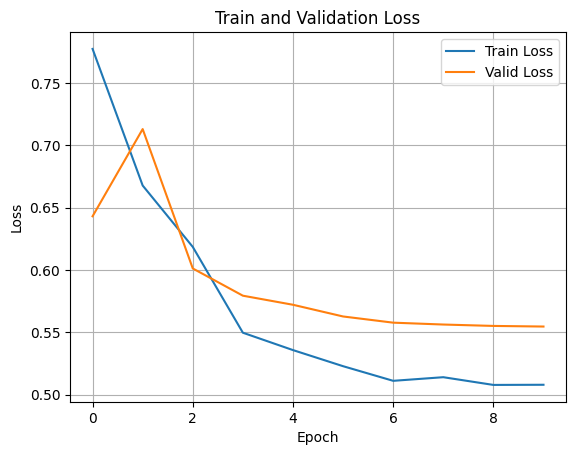

In [24]:
# Plot Loss Curves
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(valid_losses, label="Valid Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Train and Validation Loss")
plt.grid(True)
plt.savefig("loss_curve.png")
plt.show()

## Plot Overall mAP Curve

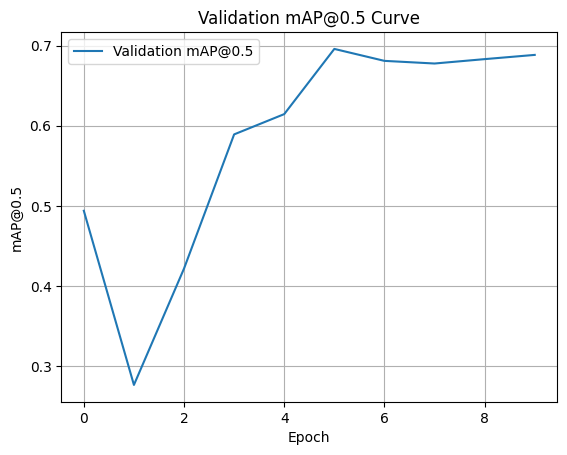

In [25]:
# Plot Overall mAP
plt.figure()
plt.plot(maps, label="Validation mAP@0.5")
plt.xlabel("Epoch")
plt.ylabel("mAP@0.5")
plt.legend()
plt.title("Validation mAP@0.5 Curve")
plt.grid(True)
plt.savefig("map_curve.png")
plt.show()

## Plot Per-Class mAP Curve

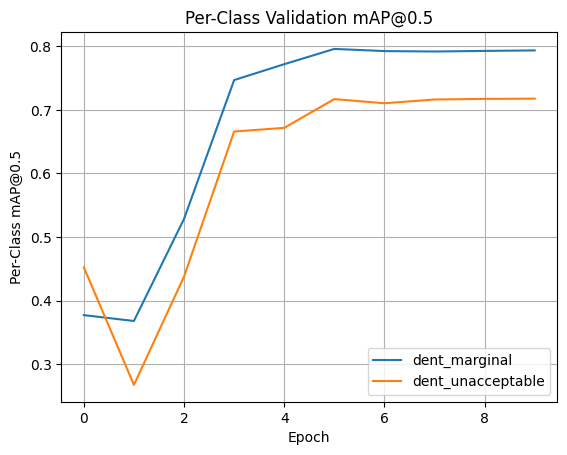

In [26]:
# Plot Per-Class mAP
plt.figure()
for c, values in per_class_maps.items():
    class_name = [k for k,v in VALID_CLASSES.items() if v == c][0]
    plt.plot(values, label=f"{class_name}")
plt.xlabel("Epoch")
plt.ylabel("Per-Class mAP@0.5")
plt.legend()
plt.title("Per-Class Validation mAP@0.5")
plt.grid(True)
plt.savefig("per_class_map_curve.png")
plt.show()

## Plot PR Curves

In [27]:
def plot_pr_curve(precision, recall, title, filename):
    plt.figure()
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.grid(True)
    plt.savefig(filename)
    plt.show()

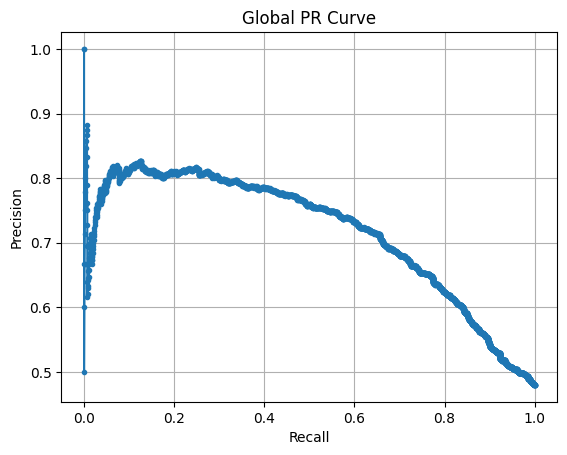

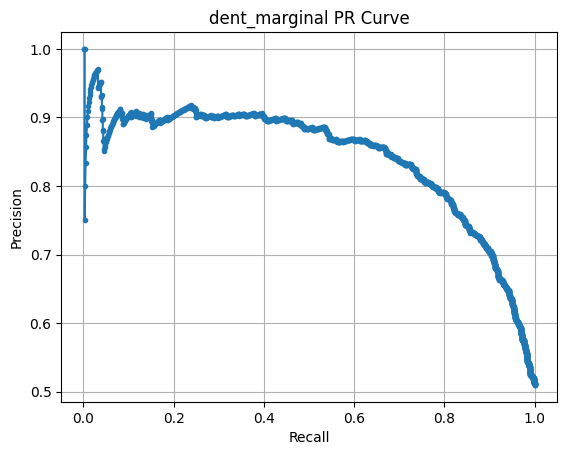

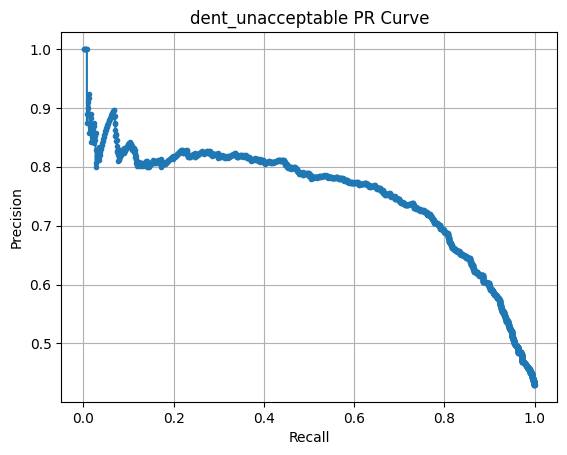

In [28]:
# Plot Global PR Curve
plot_pr_curve(global_precision, global_recall, "Global PR Curve", "global_pr_curve.png")

# Plot Per-Class PR Curves
for class_id, (precision_c, recall_c) in per_class_pr.items():
    class_name = [k for k,v in VALID_CLASSES.items() if v == class_id][0]
    plot_pr_curve(precision_c, recall_c, f"{class_name} PR Curve", f"{class_name.lower()}_pr_curve.png")

## Visualize Predictions

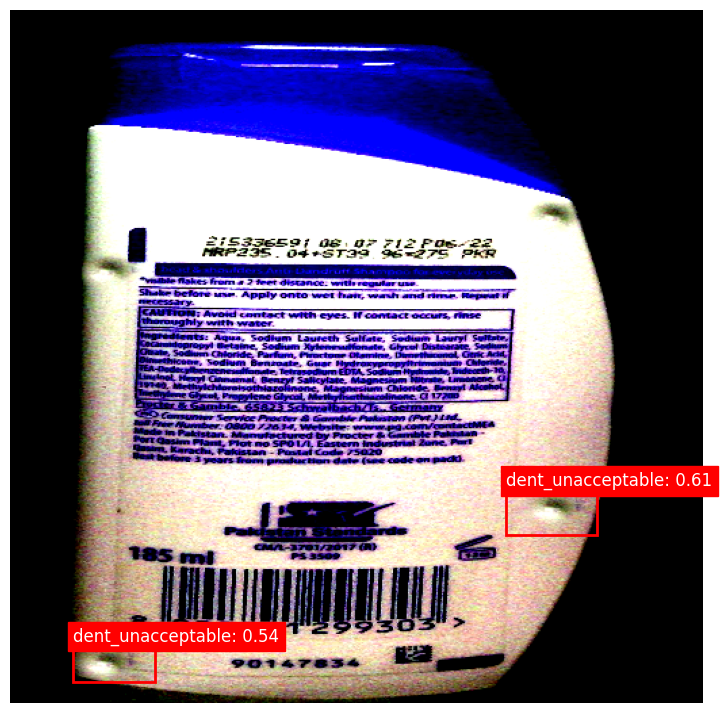

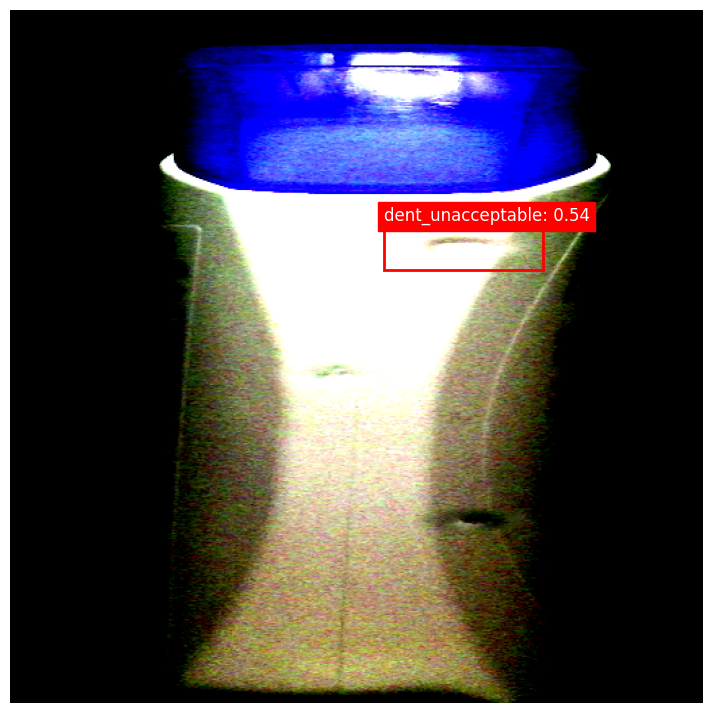

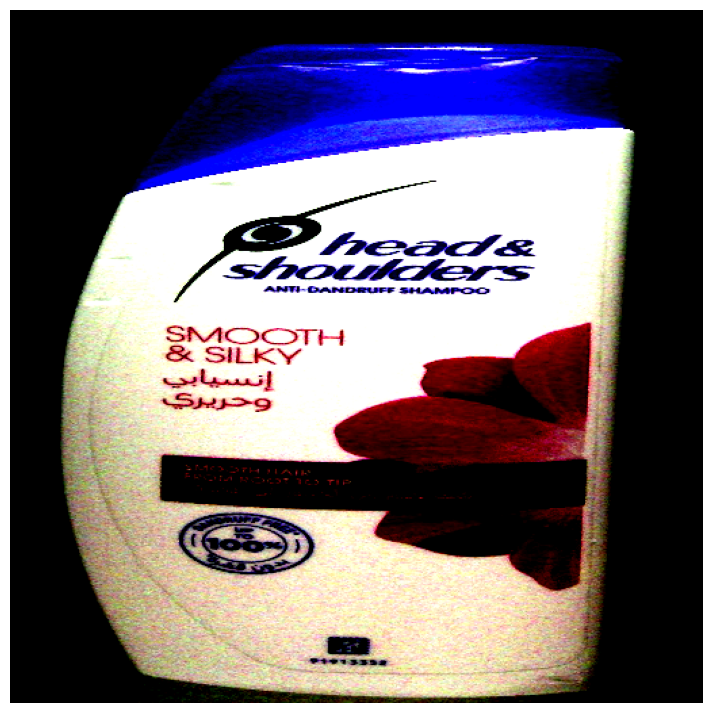

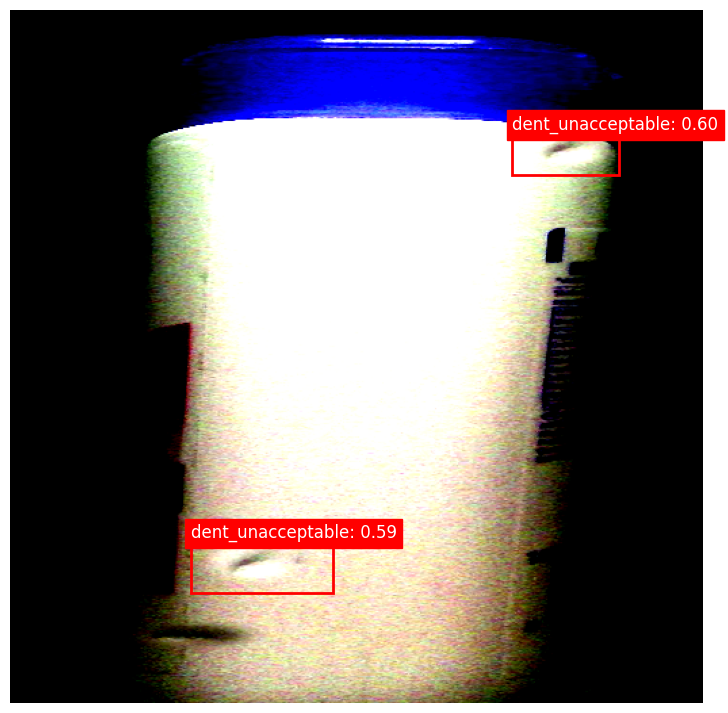

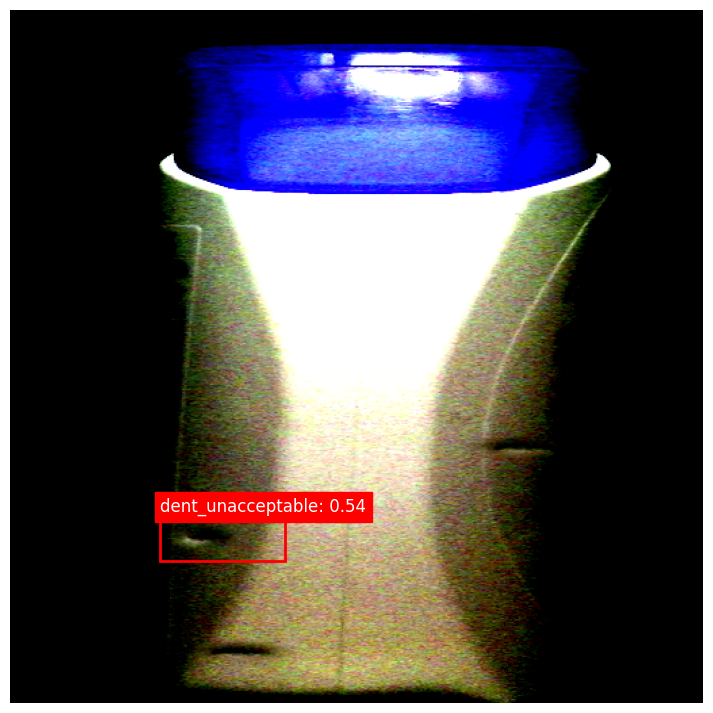

In [29]:
# Visualize Predictions

model.eval()
for i in range(5):
    img, _ = test_dataset[i]
    img = img.to(device)
    with torch.no_grad():
        prediction = model([img])

    img = img.permute(1,2,0).cpu().numpy()

    fig, ax = plt.subplots(1, 1, figsize=(12,9))
    ax.imshow(img)
    boxes = prediction[0]['boxes'].cpu().numpy()
    scores = prediction[0]['scores'].cpu().numpy()
    labels = prediction[0]['labels'].cpu().numpy()

    for box, score, label in zip(boxes, scores, labels):
        if score >= score_threshold:
            xmin, ymin, xmax, ymax = box
            width, height = xmax - xmin, ymax - ymin
            rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            label_name = [k for k,v in VALID_CLASSES.items() if v == label][0]
            ax.text(xmin, ymin, f"{label_name}: {score:.2f}", color='white', fontsize=12, backgroundcolor='red')

    plt.axis('off')
    plt.savefig(f"prediction_{i}.png")
    plt.show()